# Magnitude Pruning

This is the code for pruning. The dataset is MNIST hand-written dataset. The model is a 3-layer feed forward network.


In [1]:
# Import necessary package
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn.utils.prune as prune
import copy


In [2]:
torch.manual_seed(42)

## Load dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 5

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root = '/data', download = True, train = True, transform = transform)
test_dataset = datasets.MNIST(root = '/data', download = True, train = False, transform = transform)

train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size= 1024, shuffle = False)

## Build model
We build the same model with 2 hidden layers, each contains 64 neurons.

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28 * 28, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        return self.linear3(x)

## Define the training, evaluating loop

In [6]:
def train(model, device, train_loader, loss_fn, optimizer, epochs):
    model.train()


    for epoch in range(epochs):
        correct = 0
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, target)
            train_loss += loss
            correct += torch.eq(outputs.argmax(dim = 1), target).sum().item()
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        accuracy = 100. * correct / len(train_loader.dataset)
        print(f'Train Epoch: {epoch + 1} | Loss: {train_loss.item():.6f} Accuracy: {accuracy:.3f}%')


In [7]:
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            pred = outputs.argmax(dim = 1)
            correct += torch.eq(pred, target).sum().item()
        accuracy = 100. * (correct / len(test_loader.dataset))

    return accuracy

Following method is for pruning to calculate accuracy. (same as evaluate)

In [8]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.inference_mode():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            pred = logits.argmax(dim = 1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

We also need a function to calculate the model size.


In [9]:
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth") / 1024
    os.remove("temp.pth")
    return size

## Training a basic model

In [11]:
model_0 = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr = 0.001)
train(model_0, device, train_dataloader, loss_fn, optimizer, epochs)

Train Epoch: 1 | Loss: 169.688599 Accuracy: 89.373%
Train Epoch: 2 | Loss: 74.709229 Accuracy: 95.240%
Train Epoch: 3 | Loss: 53.370659 Accuracy: 96.548%
Train Epoch: 4 | Loss: 42.627834 Accuracy: 97.232%
Train Epoch: 5 | Loss: 34.726772 Accuracy: 97.725%


## Save the Model to "basic_model_for_pruning"

Since we will use the same model for multiple times, we can same the model and do the experiment without repeatly training basic model.

In [12]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "basic_model_for_pruning.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f = MODEL_SAVE_PATH) 

Saving model to: models\basic_model_for_pruning.pth


### Load the model so that we don't need to retrain the model.

In [13]:
loaded_basic_model = MLP()
loaded_basic_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [14]:
loaded_basic_model.to(device)
evaluate(loaded_basic_model, device, test_dataloader)

97.19

## Weight-magnitude visualization

### `model.parameters`: A first glance
We first see what are included in `model.parameters()`.

In [15]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(4, 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = SimpleModel()

all_weights = []



for name, param in model.named_parameters():
    print(name)
    print(param)
    print("\n")


fc1.weight
Parameter containing:
tensor([[ 0.4403, -0.1578,  0.0738, -0.4758],
        [-0.1308,  0.4486, -0.4420,  0.0924],
        [-0.4324, -0.2331, -0.3167,  0.3663]], requires_grad=True)


fc1.bias
Parameter containing:
tensor([ 0.0062, -0.2799,  0.2409], requires_grad=True)


fc2.weight
Parameter containing:
tensor([[-0.3118, -0.4328,  0.5106],
        [ 0.0942,  0.5241, -0.0632]], requires_grad=True)


fc2.bias
Parameter containing:
tensor([-0.3028,  0.4359], requires_grad=True)




We can see it includes two things:
* name : which is a `str`
* param : which is a `torch.nn.parameter.Parameter` object. To only get the tensor from this object, we can use the `.detach()` method.

In [16]:
for name, param in model.named_parameters():
    if 'weight' in name:
        flat_weights = param.detach().flatten() # to get a 1D tensor
        all_weights.append(flat_weights)

all_weights

[tensor([ 0.4403, -0.1578,  0.0738, -0.4758, -0.1308,  0.4486, -0.4420,  0.0924,
         -0.4324, -0.2331, -0.3167,  0.3663]),
 tensor([-0.3118, -0.4328,  0.5106,  0.0942,  0.5241, -0.0632])]

In [17]:
all_weights = torch.cat(all_weights) # combine into a single vector
all_weights

tensor([ 0.4403, -0.1578,  0.0738, -0.4758, -0.1308,  0.4486, -0.4420,  0.0924,
        -0.4324, -0.2331, -0.3167,  0.3663, -0.3118, -0.4328,  0.5106,  0.0942,
         0.5241, -0.0632])

Finally, we can sort the values.

In [18]:
sorted_weights, indices = torch.sort(all_weights, descending=True)

print("Top 10 largest weights:")
print(sorted_weights[:10])


Top 10 largest weights:
tensor([ 0.5241,  0.5106,  0.4486,  0.4403,  0.3663,  0.0942,  0.0924,  0.0738,
        -0.0632, -0.1308])


Alternative way: Only get the `weights` and `biases` from the model, don't get the `name`.

In [19]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.4403, -0.1578,  0.0738, -0.4758],
        [-0.1308,  0.4486, -0.4420,  0.0924],
        [-0.4324, -0.2331, -0.3167,  0.3663]], requires_grad=True)
Parameter containing:
tensor([ 0.0062, -0.2799,  0.2409], requires_grad=True)
Parameter containing:
tensor([[-0.3118, -0.4328,  0.5106],
        [ 0.0942,  0.5241, -0.0632]], requires_grad=True)
Parameter containing:
tensor([-0.3028,  0.4359], requires_grad=True)


### Back to our model

First create a helper function for us to transform the weight matrix into a 1D tensor

In [20]:
def flatten_abs(t): 
    '''
    Input a tensor
    Output the abs(1D flatten tensor)
    '''
    return t.detach().cpu().abs().reshape(-1)

In [21]:
global_w = torch.cat([
    flatten_abs(p) 
    for name, p in loaded_basic_model.named_parameters() 
    if p.requires_grad and "weight" in name
]) # only return unfreeze weights, in case we only train on partial model parameters

global_sorted, global_sorted_index = torch.sort(global_w) # return a sorted tensor and a index tensor
global_sorted.shape

torch.Size([54912])

In [22]:
# calculate total weight
784*64 + 64*64 + 640

54912

Finally plot the method.

C:\Users\Jorden\AppData\Local\Temp\ipykernel_15216\2500913941.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(global_sorted)), np.log10(global_sorted))


Text(0, 0.5, 'log(|w|)')

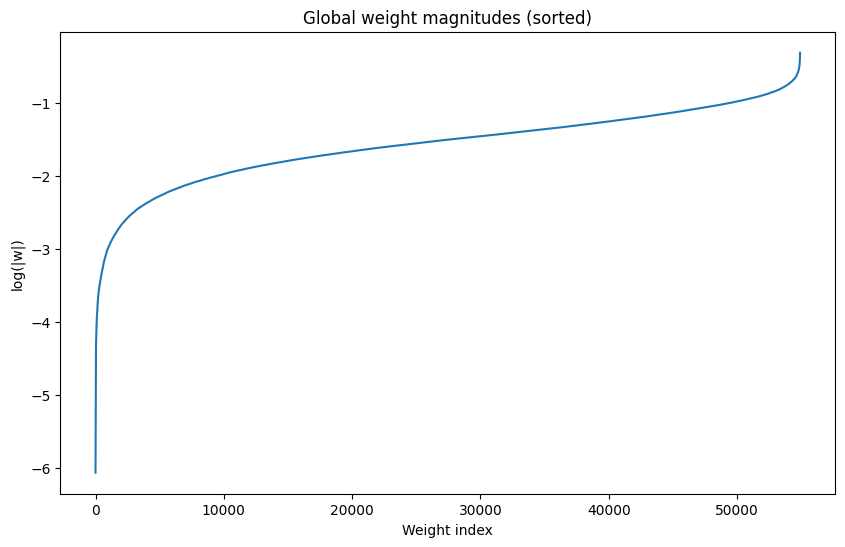

In [23]:
plt.figure(figsize = (10, 6))
plt.plot(range(len(global_sorted)), np.log10(global_sorted))
plt.title("Global weight magnitudes (sorted)")
plt.xlabel("Weight index")
plt.ylabel("log(|w|)")


We try to visualize the result based on layer.

Text(0.5, 0.98, 'weights distribution')

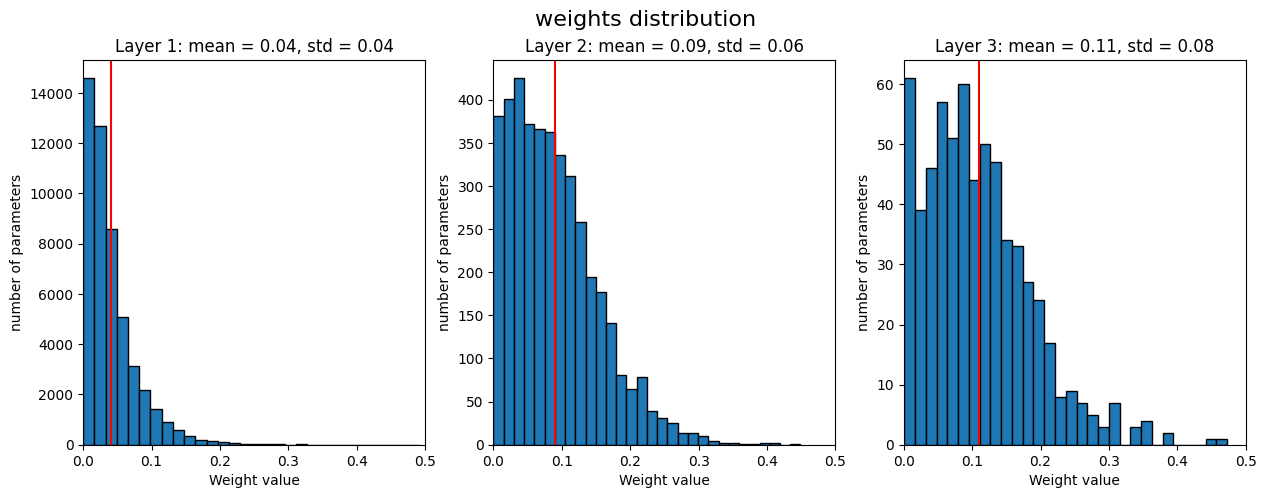

In [24]:
string = "linear"
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    layer_name = string + str(i+1)
    layer = getattr(model_0, layer_name)
    w = flatten_abs(layer.weight)
    w_sorted, w_sorted_index = torch.sort(w)
    mean = torch.mean(w_sorted)

    ax[i].axvline(mean, color = 'red')
    ax[i].hist(w_sorted, bins = 30, edgecolor='black')
    ax[i].set_title(f"Layer {i+1}: mean = {torch.mean(w_sorted):.2f}, std = {torch.std(w_sorted):.2f}")
    ax[i].set_xlabel("Weight value")
    ax[i].set_ylabel("number of parameters")
    ax[i].set_xlim(0.0, 0.5)
fig.suptitle("weights distribution", fontsize=16)

C:\Users\Jorden\AppData\Local\Temp\ipykernel_15216\1210496872.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[i].plot(range(len(w_sorted)), np.log10(w_sorted))


Text(0.5, 0.98, 'weights magnitude')

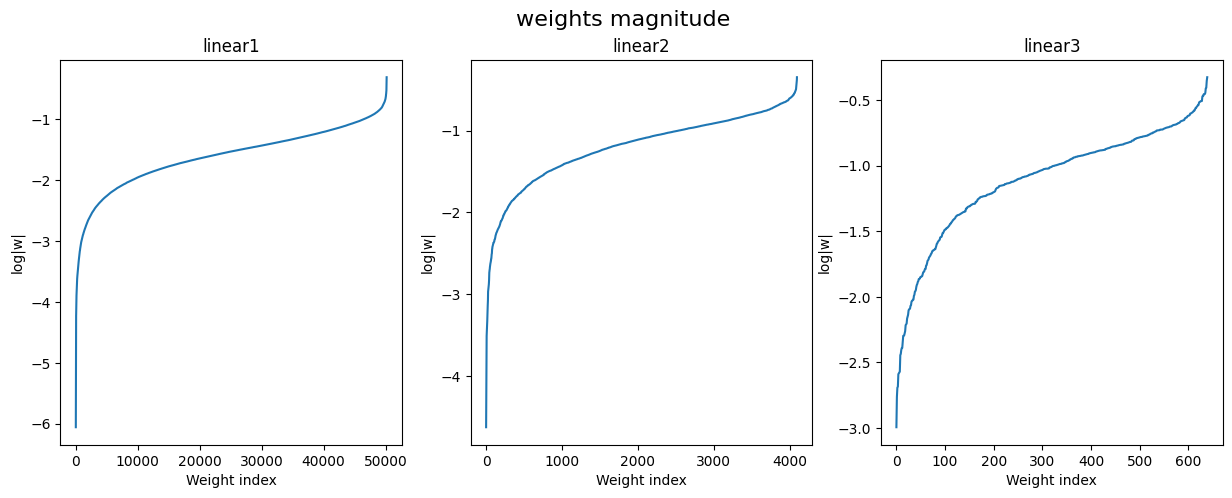

In [25]:
string = "linear"
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    layer_name = string + str(i+1)
    layer = getattr(model_0, layer_name)
    w = flatten_abs(layer.weight)
    w_sorted, w_sorted_index = torch.sort(w)

    ax[i].plot(range(len(w_sorted)), np.log10(w_sorted))
    ax[i].set_title(f"{layer_name}")
    ax[i].set_xlabel("Weight index")
    ax[i].set_ylabel("log|w|")
fig.suptitle("weights magnitude", fontsize=16)
   


Also bias

Text(0.5, 0.98, 'Biases distribution')

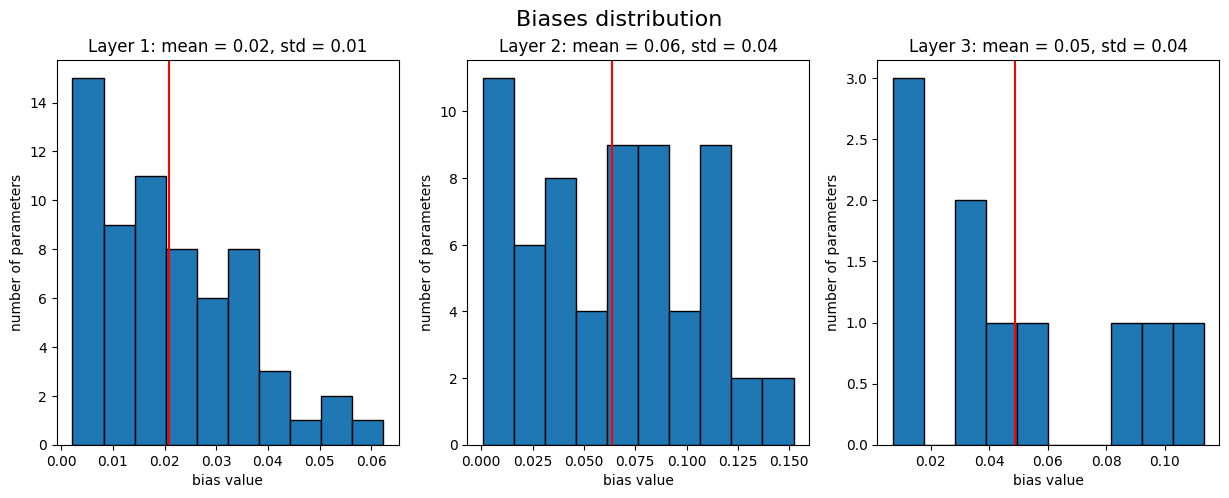

In [26]:
string = "linear"
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    layer_name = string + str(i+1)
    layer = getattr(model_0, layer_name)
    b = flatten_abs(layer.bias)
    b_sorted, w_sorted_index = torch.sort(b)
    mean = torch.mean(b_sorted)

    ax[i].axvline(mean, color = 'red')
    ax[i].hist(b_sorted, edgecolor='black')
    ax[i].set_title(f"Layer {i+1}: mean = {torch.mean(b_sorted):.2f}, std = {torch.std(b_sorted):.2f}")
    ax[i].set_xlabel("bias value")
    ax[i].set_ylabel("number of parameters")
fig.suptitle("Biases distribution", fontsize=16)

Text(0.5, 0.98, 'biases magnitude')

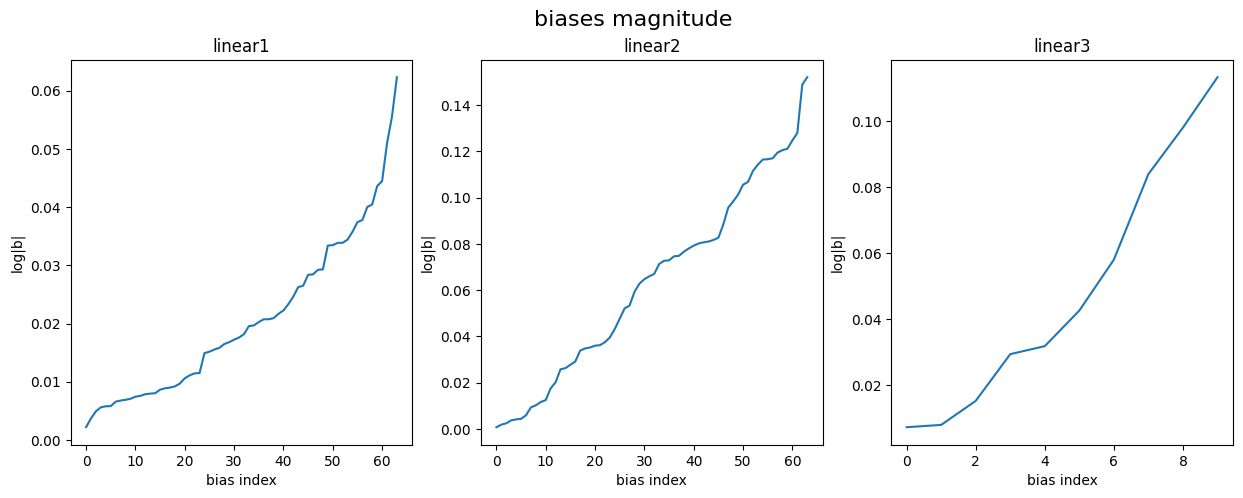

In [27]:
string = "linear"
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    layer_name = string + str(i+1)
    layer = getattr(model_0, layer_name)
    b = flatten_abs(layer.bias)
    b_sorted, w_sorted_index = torch.sort(b)

    ax[i].plot(range(len(b_sorted)), b_sorted)
    ax[i].set_title(f"{layer_name}")
    ax[i].set_xlabel("bias index")
    ax[i].set_ylabel("log|b|")
fig.suptitle("biases magnitude", fontsize=16)

## Pruning

Now we can start to prune the model. To know how the pruning influence the model, we prune the model from 0% to 100% to see what will happen.

In [28]:
prune_pcts = np.linspace(0, 1, 21)
prune_pcts

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

If you already has the model, we can load the model to avoid re-training.


In [29]:
MODEL_SAVE_PATH = 'models/basic_model_for_pruning.pth'
loaded_basic_model = MLP()
loaded_basic_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_basic_model.to(device)

MLP(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

*Important:* We use `prune.remove` to prune the model. The principle of `prune` module is basically adding one `mask_layer` to know which parameters to be set to 0. Using `remove` method, we fuse the parameter layer and mask layer together, meaning the final model size is same as original one.

In [30]:
def apply_global_prune(model, amount):
    """
    amount: fraction of *weights* to prune globally via L1-norm.
    Returns a *new* model with pruning mask applied & re-packed (remove reparam hooks).
    """

    pruned = copy.deepcopy(model).to(device)
    parameters_to_prune = [(pruned.linear1, "weight"),
                           (pruned.linear2, "weight"),
                           (pruned.linear3, "weight")]
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = amount
    )
    
    for module, weight in parameters_to_prune:
        # Permanently applies the pruning mask by removing `weight_orig` and `mask`, 
        # and replaces the weight with the pruned version (zeros remain in pruned positions).
        prune.remove(module, weight)

    return pruned

In [31]:
acc_after_prune = []
for pct in prune_pcts:
    pruned_model = apply_global_prune(loaded_basic_model, pct)
    acc = accuracy(pruned_model, test_dataloader)
    acc_after_prune.append(acc)
    model_size = get_model_size(pruned_model)
    print(f"Prune {pct:.0%} → accuracy: {acc:.4f}")

Prune 0% → accuracy: 0.9719
Prune 5% → accuracy: 0.9721
Prune 10% → accuracy: 0.9713
Prune 15% → accuracy: 0.9717
Prune 20% → accuracy: 0.9714
Prune 25% → accuracy: 0.9715
Prune 30% → accuracy: 0.9713
Prune 35% → accuracy: 0.9706
Prune 40% → accuracy: 0.9711
Prune 45% → accuracy: 0.9696
Prune 50% → accuracy: 0.9678
Prune 55% → accuracy: 0.9676
Prune 60% → accuracy: 0.9641
Prune 65% → accuracy: 0.9560
Prune 70% → accuracy: 0.9443
Prune 75% → accuracy: 0.9231
Prune 80% → accuracy: 0.8950
Prune 85% → accuracy: 0.8542
Prune 90% → accuracy: 0.6611
Prune 95% → accuracy: 0.3592
Prune 100% → accuracy: 0.1009


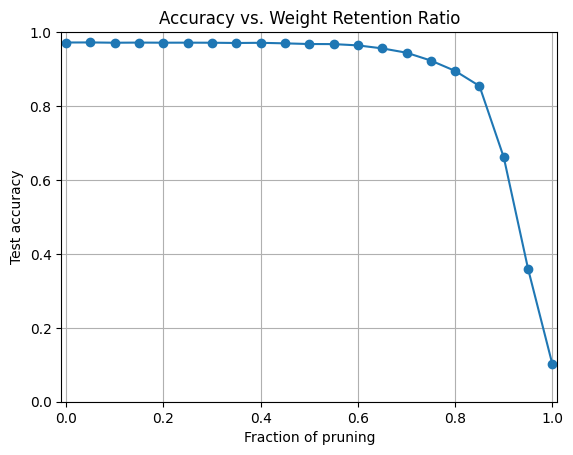

In [32]:
plt.figure()
plt.plot(prune_pcts, acc_after_prune, marker="o")
plt.title("Accuracy vs. Weight Retention Ratio")
plt.xlabel("Fraction of pruning")
plt.ylabel("Test accuracy")
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1])
plt.grid(True)

From the result, we can observe that roughly 60% is the sweet spot.

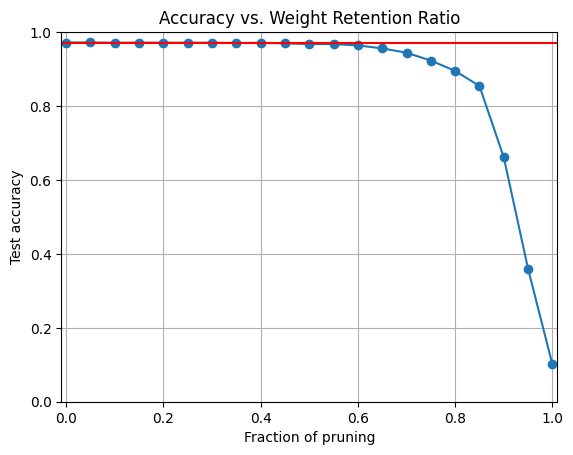

In [33]:
plt.figure()
plt.plot(prune_pcts, acc_after_prune, marker="o")
plt.axhline(0.97, color = 'red')
plt.title("Accuracy vs. Weight Retention Ratio")
plt.xlabel("Fraction of pruning")
plt.ylabel("Test accuracy")
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1])
plt.grid(True)

## Pruning and Dynamic Quantization

### Use 40% parameters to do the quantization (Pruning 60%)

Reload the model.

In [34]:
MODEL_SAVE_PATH = 'models/basic_model_for_pruning.pth'
loaded_basic_model = MLP()
loaded_basic_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_basic_model.to(device)

MLP(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [35]:
pruned_60_model = apply_global_prune(loaded_basic_model, 0.6)
acc = accuracy(pruned_60_model, test_dataloader)
model_size = get_model_size(loaded_basic_model)
acc, model_size

(0.9641, 217.291015625)

Then quantized the pruned model.

In [36]:
import torch.ao.quantization as quant
pruned_60_model = pruned_60_model.to("cpu")
dynamic_quantized_model = quant.quantize_dynamic(pruned_60_model,
                                                 {nn.Linear},
                                                 dtype = torch.qint8)

In [37]:
print("Quantized model:")
evaluate(dynamic_quantized_model, torch.device("cpu"), test_loader= test_dataloader)

Quantized model:


96.35000000000001

In [38]:
def print_size_of_model(model):
    torch.save(model.state_dict(), 'temp_delme.p')
    size = os.path.getsize('temp_delme.p') / 1024
    print('Size (KB)', size)
    os.remove('temp_delme.p')
    return size

In [39]:
print("Size of float model:")
size_before_quantize = print_size_of_model(pruned_60_model)

print("Size of quantized model:")
size_after_quantize = print_size_of_model(dynamic_quantized_model)

print(f"corresponding prining ratio: {size_after_quantize / size_before_quantize:.3f}")

Size of float model:
Size (KB) 217.662109375
Size of quantized model:
Size (KB) 58.720703125
corresponding prining ratio: 0.270


In [40]:
print(0.4*0.27)

0.10800000000000001


In [41]:
linear1_parameters = list(pruned_60_model.linear1.named_parameters())
linear1_parameters

[('bias',
  Parameter containing:
  tensor([ 0.0400, -0.0510,  0.0086,  0.0335,  0.0358,  0.0068,  0.0115, -0.0158,
          -0.0172, -0.0378, -0.0058, -0.0436,  0.0405, -0.0114,  0.0080, -0.0202,
           0.0176, -0.0207,  0.0222, -0.0022, -0.0182, -0.0069,  0.0623,  0.0293,
           0.0233, -0.0284,  0.0089, -0.0197, -0.0049, -0.0217, -0.0058,  0.0265,
          -0.0284, -0.0152,  0.0066, -0.0209, -0.0149,  0.0339, -0.0374,  0.0037,
          -0.0196, -0.0080,  0.0155, -0.0079, -0.0076,  0.0165, -0.0090,  0.0263,
           0.0555, -0.0074,  0.0111,  0.0207,  0.0168, -0.0071,  0.0339, -0.0292,
          -0.0344,  0.0246, -0.0106, -0.0334, -0.0445, -0.0056,  0.0092, -0.0097],
         requires_grad=True)),
 ('weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000, -0.0000,  ..., -0.0410, -0.0000, -0.0000],
          [-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000,  0.0000],
          ...,
          [

## Put pruning and quantization methods together

In [42]:
print(f"Dynamic Quantization | Before : 217.29, After : 58.52, Pruning Ratio : {(217.29 - 58.52)/217.29:.3f}")
print(f"Post Training Quantization | Before : 217.29, After : 62.08, Pruning Ratio : {(217.29 - 62.08)/217.29:.3f}")
print(f"Quantization Aware Training| Before : 217.29, After : 62.08, Pruning Ratio : {(217.29 - 62.08)/217.29:.3f}")

Dynamic Quantization | Before : 217.29, After : 58.52, Pruning Ratio : 0.731
Post Training Quantization | Before : 217.29, After : 62.08, Pruning Ratio : 0.714
Quantization Aware Training| Before : 217.29, After : 62.08, Pruning Ratio : 0.714


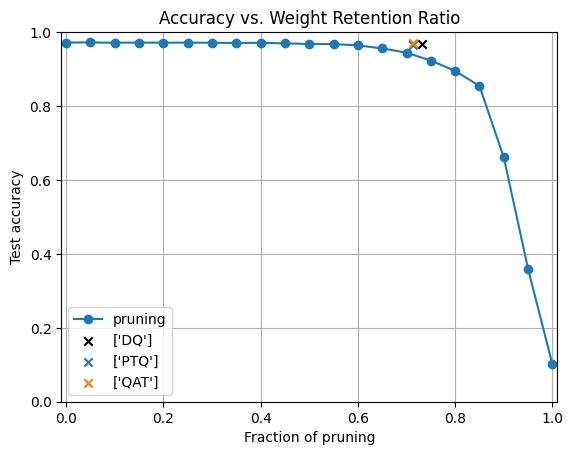

In [46]:
plt.figure()
plt.plot(prune_pcts, acc_after_prune, marker="o", label = 'pruning')
plt.title("Accuracy vs. Weight Retention Ratio")
plt.scatter([0.731], [0.9668], label = ['DQ'], marker= 'x', c = 'black')
plt.scatter([0.714], [0.9653], label = ['PTQ'], marker= 'x')
plt.scatter([0.714], [0.9714], label = ['QAT'], marker= 'x')
plt.xlabel("Fraction of pruning")
plt.ylabel("Test accuracy")
plt.xlim([-0.01, 1.01])
plt.ylim([0, 1])
plt.legend()
plt.grid(True)